In [ ]:
import os
import sys
from PIL import Image
import numpy as np
import shutil

sys.path.extend(['..'])

from utils.config import process_config

import tensorflow as tf
from tensorflow.layers import (conv2d, max_pooling2d, average_pooling2d, batch_normalization, dropout, dense)
from tensorflow.nn import (relu, softmax, leaky_relu)
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle

In [ ]:
# Paths to use later
DATA = '../data_splitted/'
CONF = '../configs/roman.json'

# Configs creating

In [6]:
config_tf = tf.ConfigProto(allow_soft_placement=True)
config_tf.gpu_options.allow_growth = True
config_tf.gpu_options.per_process_gpu_memory_fraction = 0.95

In [7]:
config = process_config(CONF)

# Necessary functions

In [ ]:
def normalize(image):
    return (image - image.min()) / (image.max() - image.min())

def shuffle_sim(a, b):
    assert a.shape[0] == a.shape[0], 'Shapes must be equal'
    
    ind = np.arange(a.shape[0])
    np.random.shuffle(ind)
    return a[ind], b[ind]

In [ ]:
def read_train_test(path_to_data):
    data = {}
    for dset in ['train', 'test']:
        path_ = os.path.join(path_to_data, dset)
        X, Y = [], []
        classes = [d for d in os.listdir(path_) if os.path.isdir(os.path.join(path_, d))]
        classes.sort()
        
        for cl in classes:
            y = np.zeros((1, 8), dtype=np.int32)
            y[0, int(cl) - 1] = 1
            
            cl_path = os.path.join(path_, cl)
            filenames = [os.path.join(cl_path, pict) for pict in os.listdir(cl_path) if pict.endswith('.jpg')]
            
            for im in filenames:
                image = np.asarray(Image.open(im), dtype=np.float32)
                X.append(normalize(image).reshape((1, image.shape[0], image.shape[1], image.shape[2])))
                Y.append(y)
        
        a, b = shuffle_sim(np.concatenate(X), np.concatenate(Y))
        data[dset] = ([a, b])
    return data

# Model

In [5]:
class Model():
    """
    Model class represents one object of model.

    :param config: Parsed config file.
    :param session_config: Formed session config file, if necessary.

    :return Model
    """
    
    def __init__(self, config, session_config=None):

        # Configuring session
        self.config = config
        if session_config is not None:
            self.sess = tf.Session(config=session_config)
        else:
            self.sess = tf.Session()

        # Creating inputs to network
        with tf.name_scope('inputs'):
            self.x = tf.placeholder(
                dtype=tf.float32,
                shape=(None, config.image_size, config.image_size, 3))
            self.y = tf.placeholder(dtype=tf.int32, shape=(None, 8))
            self.training = tf.placeholder(dtype=tf.bool, shape=())

        # Creating epoch counter
        self.global_epoch = tf.Variable(
            0, name='global_epoch', trainable=False, dtype=tf.int32)
        self.step = tf.assign(self.global_epoch, self.global_epoch + 1)

        # Building model
        if self.config.write_histograms:
            self.histograms = {}
        self.__build_model()

        # Summary writer
        self.summ_writer_train = tf.summary.FileWriter(
            config.train_summary_dir, graph=self.sess.graph)
        self.summ_writer_test = tf.summary.FileWriter(config.test_summary_dir)

        self.sess.run(tf.global_variables_initializer())

        # Saver
        self.saver = tf.train.Saver(max_to_keep=1, name='saver')

    def __initialize_local(self):
        """
        Initialize local tensorflow variables.
        
        :return None
        """

        self.sess.run(tf.local_variables_initializer())
        if self.config.write_histograms:
            self.histograms = {}

    def __add_histogram(self, scope, name, var):
        """
        Add histograms to summary scope.
        
        :param scope: Scope object.
        :param name: Name of variable.
        :param var: Variable to add to histograms.
        
        :return None
        """

        dict_var = scope.name + '/' + name
        hist = self.histograms.get(dict_var, None)
        if hist is not None:
            self.histograms[dict_var] = tf.concat([hist, var], 0)
        else:
            self.histograms[dict_var] = var
        tf.summary.histogram(name, self.histograms[dict_var])

    def __block(self,
                inp,
                ch,
                num,
                c_ker=[(3, 3), (3, 3)],
                c_str=[(1, 1), (1, 1)],
                act=relu,
                mp_ker=(2, 2),
                mp_str=(2, 2),
                mode='conc'):
        """
        Create single convolution block of network.
        
        :param inp: Input Tensor of shape (batch_size, inp_size, inp_size, channels).
        :param ch: Number of channels to have in output Tensor.
                   (If mode is 'conc', number of channels will be ch * 2)
        :param num: Number of block for variable scope.
        :param c_ker: List of tuples with shapes of kernels for each convolution operation. 
        :param c_str: List of tuples with shapes of strides for each convolution operation.
        :param act: Activation function.
        :param mp_ker: Tuple-like pooling layer kernel size.
        :param mp_str: Tuple-like pooling layer stride size.
        :param mode: One of ['conc', 'mp', 'ap'] modes, where 'mp' and 'ap' are max- and average- 
                    pooling respectively, and 'conc' - concatenate mode. 
        
        :return Transformed Tensor
        """

        with tf.variable_scope('block_' + str(num)) as name:
            conv1 = conv2d(inp, ch, c_ker[0], strides=c_str[0])
            bn = batch_normalization(conv1)
            out = act(bn)
            if config.use_dropout_block:
                out = dropout(
                    out, config.dropout_rate_block, training=self.training)
            print(out.shape)

            conv2 = conv2d(out, ch, c_ker[1], strides=c_str[1])
            bn = batch_normalization(conv2)
            out = act(bn)
            print(out.shape)

            if config.write_histograms:
                self.__add_histogram(name, 'conv1', conv1)
                self.__add_histogram(name, 'conv2', conv2)

            if mode == 'mp':
                out = max_pooling2d(out, mp_ker, strides=mp_str)
            elif mode == 'ap':
                out = average_pooling2d(out, mp_ker, mp_str)
            elif mode == 'conc':
                mp = max_pooling2d(out, mp_ker, strides=mp_str)
                ap = average_pooling2d(out, mp_ker, mp_str)
                out = tf.concat([mp, ap], -1)
            else:
                raise ValueError('Unknown mode.')

            print(out.shape)
        return out

    def __build_model(self):
        """
        Build model.
        
        :return None
        """
        
        with tf.name_scope('layers'):
            out = self.__block(self.x, 16, 1, mode='conc')
            out = self.__block(out, 32, 2, mode='conc')
            out = self.__block(out, 64, 3, mode='conc')
            out = self.__block(out, 256, 4, c_str=[(1, 1), (2, 2)], mode='mp')

            dim = np.prod(out.shape[1:])
            out = tf.reshape(out, [-1, dim])
            print(out.shape)

            with tf.variable_scope('dense') as scope:
                dense_l = dense(out, 128)
                out = batch_normalization(dense_l)
                out = leaky_relu(out, alpha=0.01)
                if config.use_dropout_dense:
                    out = dropout(
                        out,
                        rate=config.dropout_rate_dense,
                        training=self.training)
                print(out.shape)

                self.predictions = dense(out, 8, activation=softmax)

                if self.config.write_histograms:
                    self.__add_histogram(scope, 'dense', dense_l)
                    self.__add_histogram(scope, 'pred', self.predictions)

        with tf.name_scope('metrics'):
            amax_labels = tf.argmax(self.y, 1)
            amax_pred = tf.argmax(self.predictions, 1)

            cur_loss = tf.losses.softmax_cross_entropy(self.y,
                                                       self.predictions)
            self.loss, self.loss_update = tf.metrics.mean(cur_loss)

            cur_acc = tf.reduce_mean(
                tf.cast(tf.equal(amax_labels, amax_pred), dtype=tf.float32))
            self.acc, self.acc_update = tf.metrics.mean(cur_acc)

            self.optimize = tf.train.AdamOptimizer(
                self.config.learning_rate).minimize(cur_loss)

            tf.summary.scalar('loss', self.loss)
            tf.summary.scalar('accuracy', self.acc)

        self.summary = tf.summary.merge_all()

    def train(self, dat, epochs, dat_v=None, batch=None):
        """
        Train model on data.
        
        :param dat: List of data to train on, like [X, y].
                    Where X is an array with size (None, image_size, image_size, 3) and
                    y is an array with size (None ,8).
        :param epochs: Number of epochs to run training procedure.
        :param dat_v: List of data to validate on, like [X, y].
                    Where X is an array with size (None, image_size, image_size, 3) and
                    y is an array with size (None ,8).
        :param batch: Batch size to train on.
        
        :return None
        """
        
        if batch is not None:
            steps = int(np.ceil(dat[0].shape[0] / batch))
        else:
            batch = dat[0].shape[0]
            steps = 1

        for epoch in range(epochs):
            self.__initialize_local()
            summary = tf.summary.Summary()

            for step in range(steps):
                start = step * batch
                finish = (
                    step + 1) * batch if step + 1 != steps else dat[0].shape[0]

                _, _, _ = self.sess.run(
                    [self.loss_update, self.acc_update, self.optimize],
                    feed_dict={
                        self.x: dat[0][start:finish],
                        self.y: dat[1][start:finish],
                        self.training: True
                    })

            summary, loss, acc, ep = self.sess.run(
                [self.summary, self.loss, self.acc, self.step])
            self.summ_writer_train.add_summary(summary, ep)
            print(
                'EP: {:3d}\tLOSS: {:.10f}\tACC: {:.10f}\t'.format(
                    ep, loss, acc),
                end='')

            if dat_v is not None:
                self.test(dat_v, batch=batch)
            else:
                print()

    def test(self, dat, batch=None):
        """
        Test model on specific data.
        
        :param dat: List of data to test on, like [X, y].
                    Where X is an array with size (None, image_size, image_size, 3) and
                    y is an array with size (None ,8)..
        :param batch: Batch size to use.
        
        :return None
        """
        
        if batch is not None:
            steps = int(np.ceil(dat[0].shape[0] / batch))
        else:
            steps = 1
            batch = dat[0].shape[0]

        self.__initialize_local()
        for step in range(steps):
            start = step * batch
            finish = (
                step + 1) * batch if step + 1 != steps else dat[0].shape[0]

            _, _ = self.sess.run(
                [self.loss_update, self.acc_update],
                feed_dict={
                    self.x: dat[0][start:finish],
                    self.y: dat[1][start:finish],
                    self.training: False
                })

        summary, loss, acc, ep = self.sess.run(
            [self.summary, self.loss, self.acc, self.global_epoch])
        self.summ_writer_test.add_summary(summary, ep)
        print('VALID\tLOSS: {:.10f}\tACC: {:.10f}'.format(loss, acc))

    def predict_proba(self, data, batch=None):
        """
        Predict probability of each class.
        
        :param data: An array to predict on with shape (None, image_size, image_size, 3)
        :param batch: Batch size to use.
        
        :return Array of predictions with shape (None, 8)
        """
        
        if batch is not None:
            steps = int(np.ceil(data.shape[0] / batch))
        else:
            steps = 1
            batch = data.shape[0]

        self.__initialize_local()

        preds_arr = []
        for step in range(steps):
            start = step * batch
            finish = (step + 1) * batch if step + 1 != steps else data.shape[0]

            preds = self.sess.run(
                self.predictions,
                feed_dict={
                    self.x: data[start:finish],
                    self.y: np.zeros((finish - start, 8)),
                    self.training: False
                })
            preds_arr.append(preds)

        return np.concatenate(preds_arr)

    def save_model(self, model_path=None):
        """
        Save model weights to the folder with weights.
        
        :param model_path: String-like path to save in.
        
        :return None
        """
        
        gstep = self.sess.run(self.global_epoch)
        if model_path is not None:
            self.saver.save(self.sess, model_path + 'model')
        else:
            self.saver.save(self.sess, config.checkpoint_dir + 'model')

    def load_model(self, model_path=None):
        """
        Load model weights.
        
        :param model_path: String-like path to load from.
        
        :return None
        """
        
        if model_path is not None:
            meta = [
                os.path.join(filename) for filename in os.listdir(model_path)
                if filename.endswith('.meta')
            ][0]
            self.saver = tf.train.import_meta_graph(
                os.path.join(model_path, meta))
            self.saver.restore(self.sess,
                               tf.train.latest_checkpoint(model_path))
        else:
            meta = [
                os.path.join(filename)
                for filename in os.listdir(self.config.checkpoint_dir)
                if filename.endswith('.meta')
            ][0]
            self.saver = tf.train.import_meta_graph(
                os.path.join(self.config.checkpoint_dir, meta))
            self.saver.restore(
                self.sess,
                tf.train.latest_checkpoint(self.config.checkpoint_dir))

    def plot_misclassified(self, data, batch=None):
        """
        Create and display a plot with misclassified images.
        
        :param data:
        :param batch:
        
        :return None
        """
        
        predicted = np.argmax(self.predict_proba(data[0], batch), axis=1)
        real = np.argmax(data[1], axis=1)

        matches = (real != predicted)
        mism_count = np.sum(matches.astype(np.int32))
        images = data[0][matches]
        misk = predicted[matches]

        columns = 4
        rows = int(np.ceil(mism_count / columns))
        fig = plt.figure(figsize=(16, rows * 3))
        fig.suptitle(
            '{} photos were misclassiified.'.format(mism_count),
            fontsize=16,
            fontweight='bold')
        for i in range(mism_count):
            s_fig = fig.add_subplot(rows, columns, i + 1)
            s_fig.set_title('Classified as {}'.format(misk[i] + 1))
            plt.imshow(images[i])
        plt.show()

    def close(self):
        """
        Close a session of model to load next one.
        
        :retun None
        """
        
        self.sess.close()
        tf.reset_default_graph()

In [9]:
# Creating model object
m = Model(config, config_tf)

(?, 126, 126, 16)
(?, 124, 124, 16)
(?, 62, 62, 32)
(?, 60, 60, 32)
(?, 58, 58, 32)
(?, 29, 29, 64)
(?, 27, 27, 64)
(?, 25, 25, 64)
(?, 12, 12, 128)
(?, 10, 10, 256)
(?, 4, 4, 256)
(?, 2, 2, 256)
(?, 1024)
(?, 128)


In [10]:
# Loading previous model's weights
m.load_model()

INFO:tensorflow:Restoring parameters from ../weights/4bl_batch/model


In [11]:
# Reading train and test data
dat = read_train_test(DATA)

In [12]:
# Training model
# IT IS NOT NECESSARY HERE, BUT THERE ARE LOGS FOR YOU TO SEE
m.train(dat['train'], dat_v=dat['test'], epochs=100, batch=512)

EP: 952	LOSS: 1.2879177332	ACC: 0.9855833650	VALID	LOSS: 1.2836978436	ACC: 0.9905711412
EP: 953	LOSS: 1.2981737852	ACC: 0.9756662846	VALID	LOSS: 1.2852492332	ACC: 0.9891567826
EP: 954	LOSS: 1.2948708534	ACC: 0.9793747663	VALID	LOSS: 1.2887247801	ACC: 0.9842739701
EP: 955	LOSS: 1.2962471247	ACC: 0.9779562950	VALID	LOSS: 1.2872936726	ACC: 0.9866648912
EP: 956	LOSS: 1.3014912605	ACC: 0.9723750353	VALID	LOSS: 1.2948012352	ACC: 0.9786503315
EP: 957	LOSS: 1.3054916859	ACC: 0.9677904248	VALID	LOSS: 1.2848935127	ACC: 0.9895945787
EP: 958	LOSS: 1.3040245771	ACC: 0.9699753523	VALID	LOSS: 1.2893249989	ACC: 0.9846612215
EP: 959	LOSS: 1.3023107052	ACC: 0.9717136621	VALID	LOSS: 1.2870891094	ACC: 0.9870015979
EP: 960	LOSS: 1.2985929251	ACC: 0.9752367139	VALID	LOSS: 1.2847663164	ACC: 0.9892578125
EP: 961	LOSS: 1.2961081266	ACC: 0.9780907035	VALID	LOSS: 1.2826277018	ACC: 0.9912109375
EP: 962	LOSS: 1.2914628983	ACC: 0.9824852347	VALID	LOSS: 1.2857968807	ACC: 0.9881802201
EP: 963	LOSS: 1.2894526720	ACC: 

EP: 1045	LOSS: 1.2854274511	ACC: 0.9886814356	VALID	LOSS: 1.2885462046	ACC: 0.9856377840
EP: 1046	LOSS: 1.2869843245	ACC: 0.9870775342	VALID	LOSS: 1.2819535732	ACC: 0.9921369553
EP: 1047	LOSS: 1.2806397676	ACC: 0.9933788180	VALID	LOSS: 1.2785118818	ACC: 0.9956054688
EP: 1048	LOSS: 1.2809399366	ACC: 0.9931346774	VALID	LOSS: 1.2795132399	ACC: 0.9946289062
EP: 1049	LOSS: 1.2808495760	ACC: 0.9931053519	VALID	LOSS: 1.2797621489	ACC: 0.9941406250
EP: 1050	LOSS: 1.2811387777	ACC: 0.9928442240	VALID	LOSS: 1.2799123526	ACC: 0.9941406250
EP: 1051	LOSS: 1.2800413370	ACC: 0.9940649271	VALID	LOSS: 1.2813329697	ACC: 0.9926757812


In [13]:
# Saving model weights
# IT IS NOT NECESSARY HERE, IF YOU DIDN'T TRAIN MODEL
m.save_model()

# Plotting misclassified images

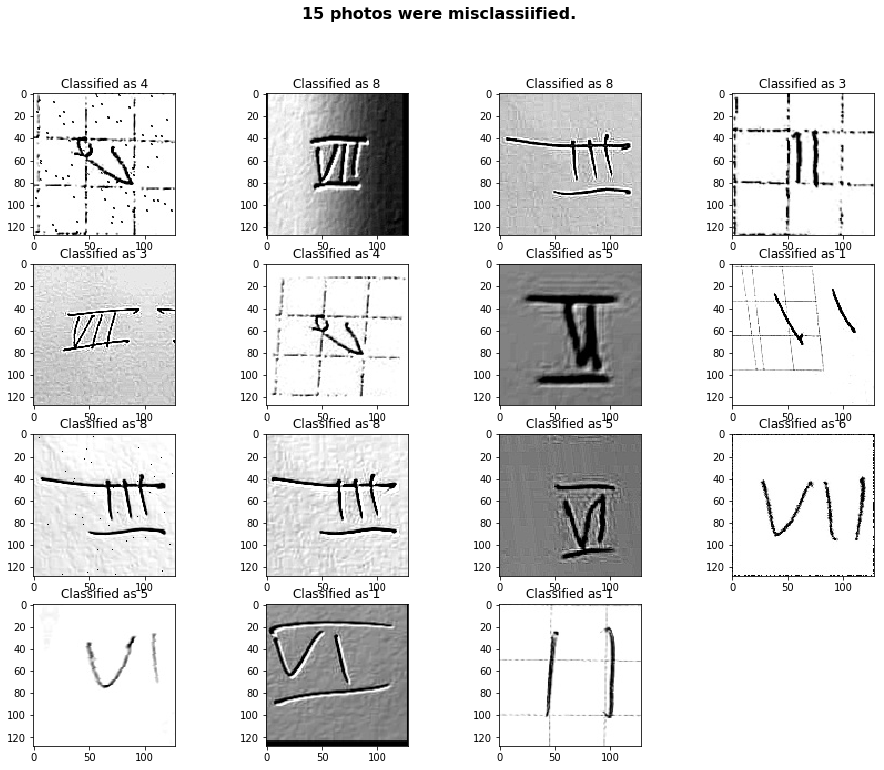

In [15]:
m.plot_misclassified(dat['train'], batch=256)

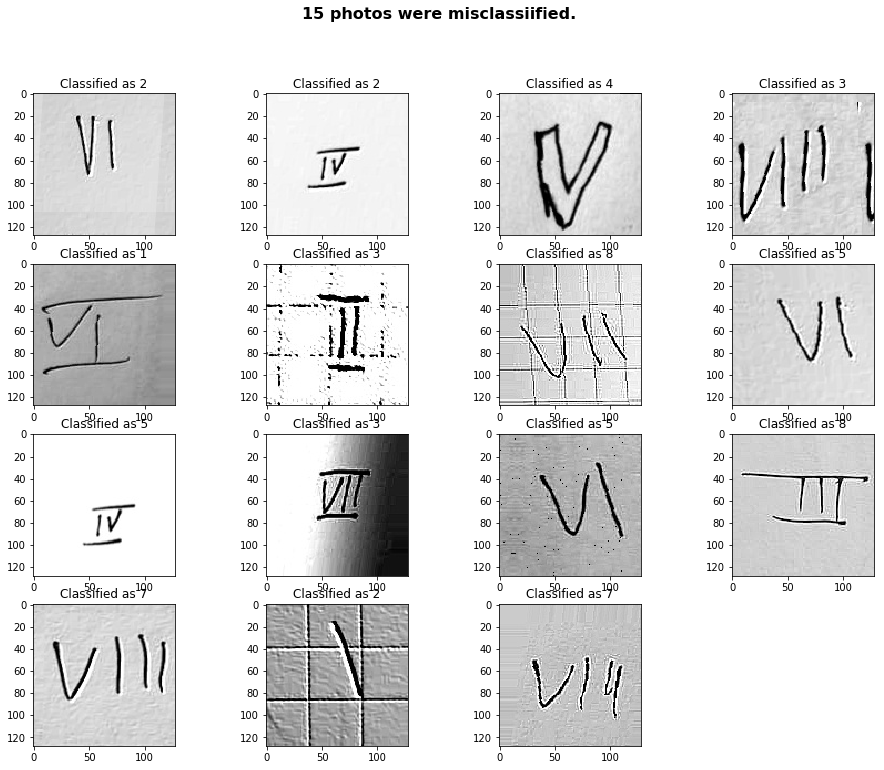

In [16]:
m.plot_misclassified(dat['test'], batch=256)

In [20]:
m.close()